In [ ]:
!pip install transformers
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import pipeline,PretrainedConfig,AutoTokenizer


model_checkpoint = "fgiuhsdfkjhfv/longsec_withno_cut"
tokenizer = AutoTokenizer.from_pretrained("pszemraj/led-large-book-summary")
sum = pipeline("summarization", model=model_checkpoint, tokenizer=tokenizer, device=0, use_auth_token=True)

In [ ]:
!pip install nltk
!git clone https://github.com/Yale-LILY/QMSum.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'QMSum'...
remote: Enumerating objects: 806, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 806 (delta 1), reused 0 (delta 0), pack-reused 804
Receiving objects: 100% (806/806), 13.76 MiB | 19.04 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [ ]:
import json

# read the dataset
# please enter the path of your data
split = 'test'
data_path = 'QMSum/data/ALL/jsonl/' + split + '.jsonl'
data = []
with open(data_path) as f:
    for line in f:
        data.append(json.loads(line))
n_meetings = len(data)
print('Total {} meetings in the {} set.'.format(n_meetings, split))

Total 35 meetings in the test set.


In [ ]:
from nltk import word_tokenize
# tokneize a sent
def tokenize(sent):
    tokens = ' '.join(word_tokenize(sent.lower()))
    return tokens

In [ ]:
def clean_data(text):
    text = text.replace('{ vocalsound } ', '')
    text = text.replace('{ disfmarker } ', '')
    text = text.replace('a_m_i_', 'ami')
    text = text.replace('l_c_d_', 'lcd')
    text = text.replace('p_m_s', 'pms')
    text = text.replace('t_v_', 'tv')
    text = text.replace('{ pause } ', '')
    text = text.replace('{ nonvocalsound } ', '')
    text = text.replace('{ gap } ', '')
    return text

In [ ]:
import nltk
nltk.download('punkt')

# process data for BART
# the input of the model here is the gold span corresponding to each query
bart_data_gold = []
for i in range(len(data)):
    # get meeting content
    entire_src = []
    for k in range(len(data[i]['meeting_transcripts'])):
        cur_turn = data[i]['meeting_transcripts'][k]['speaker'].lower() + ': '
        cur_turn = cur_turn + tokenize(data[i]['meeting_transcripts'][k]['content'])
        entire_src.append(cur_turn)
    entire_src = ' '.join(entire_src)
    for j in range(len(data[i]['general_query_list'])):
        cur = {}
        query = tokenize(data[i]['general_query_list'][j]['query'])
        cur['src'] = clean_data('<s> ' + query + ' </s> ' + entire_src + ' </s>')
        target = tokenize(data[i]['general_query_list'][j]['answer'])
        cur['tgt'] = target
        bart_data_gold.append(cur)
    for j in range(len(data[i]['specific_query_list'])):
        cur = {}
        query = tokenize(data[i]['specific_query_list'][j]['query'])
        src = []
        # get the content in the gold span for each query
        for span in data[i]['specific_query_list'][j]['relevant_text_span']:
            assert len(span) == 2
            st, ed = int(span[0]), int(span[1])
            for k in range(st, ed + 1):
                cur_turn = data[i]['meeting_transcripts'][k]['speaker'].lower() + ': '
                cur_turn = cur_turn + tokenize(data[i]['meeting_transcripts'][k]['content'])
                src.append(cur_turn)
        src = ' '.join(src)
        cur['src'] = clean_data('<s> ' + query + ' </s> ' + src + ' </s>')
        target = tokenize(data[i]['specific_query_list'][j]['answer'])
        cur['tgt'] = target
        bart_data_gold.append(cur)

print('Total {} query-summary pairs in the {} set'.format(len(bart_data_gold), split))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Total 281 query-summary pairs in the test set


In [ ]:
import nltk
nltk.download('punkt')

# process data for BART
# the input of the model here is the gold span corresponding to each query
bart_data_gold = []
for i in range(len(data)):
    # get meeting content
    entire_src = []
    for k in range(len(data[i]['meeting_transcripts'])):
        cur_turn = data[i]['meeting_transcripts'][k]['speaker'].lower() + ': '
        cur_turn = cur_turn + tokenize(data[i]['meeting_transcripts'][k]['content'])
        entire_src.append(cur_turn)
    entire_src = ' '.join(entire_src)
    for j in range(len(data[i]['general_query_list'])):
        cur = {}
        query = tokenize(data[i]['general_query_list'][j]['query'])
        cur['src'] = clean_data('<s> ' + query + ' </s> ' + entire_src + ' </s>')
        target = tokenize(data[i]['general_query_list'][j]['answer'])
        cur['tgt'] = target
        bart_data_gold.append(cur)
    for j in range(len(data[i]['specific_query_list'])):
        cur = {}
        query = tokenize(data[i]['specific_query_list'][j]['query'])
        cur['src'] = clean_data('<s> ' + query + ' </s> ' + entire_src + ' </s>')
        target = tokenize(data[i]['specific_query_list'][j]['answer'])
        cur['tgt'] = target
        bart_data_gold.append(cur)

print('Total {} query-summary pairs in the {} set'.format(len(bart_data_gold), split))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total 281 query-summary pairs in the test set


In [ ]:
import nltk
nltk.download('punkt')

# process data for BART
# the input of the model here is the gold span corresponding to each query
bart_data_gold = []
for i in range(len(data)):
    # get meeting content
    entire_src = []
    for k in range(len(data[i]['meeting_transcripts'])):
        cur_turn = data[i]['meeting_transcripts'][k]['speaker'].lower() + ': '
        cur_turn = cur_turn + tokenize(data[i]['meeting_transcripts'][k]['content'])
        entire_src.append(cur_turn)
    entire_src = ' '.join(entire_src)
    for j in range(len(data[i]['general_query_list'])):
        cur = {}
        query = tokenize(data[i]['general_query_list'][j]['query'])
        cur['src'] = clean_data('<s> ' + query + ' </s> ' + entire_src + ' </s>')
        target = tokenize(data[i]['general_query_list'][j]['answer'])
        cur['tgt'] = target
        bart_data_gold.append(cur)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=ee6140cf8cfd890927015bc16ae84e5f0a058b0de124ef01d1c976120c503694
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install evaluate
!pip install rouge_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5bd3bf64fd3b92499bb97d8502904fdfebff38b84d83fb30c95860ddf897a959
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
test=[bart_data_gold[i]["src"] for i in range(len(bart_data_gold))]

In [ ]:
out = sum(test,truncation=True, max_length=16384)

Your max_length is set to 16384, but your input_length is only 13568. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6784)
Your max_length is set to 16384, but your input_length is only 8127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4063)
Your max_length is set to 16384, but your input_length is only 6817. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3408)
Your max_length is set to 16384, but your input_length is only 15513. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('.

In [ ]:
predict = [out[i]['summary_text'] for i in range(len(out))]
label = [bart_data_gold[i]['tgt'] for i in range(len(bart_data_gold))]

In [ ]:
import evaluate

scorer = evaluate.load('rouge')
result = scorer.compute(predictions=predict, references=label)

In [ ]:
result

{'rouge1': 0.3283852454598638,
 'rouge2': 0.0727565945737984,
 'rougeL': 0.1760183344706613,
 'rougeLsum': 0.17670497699997084}

In [ ]:
from tqdm import tqdm
from rouge_score import rouge_scorer

rouge = []
for i in tqdm(range(len(out))):
  scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
  rouge_1= scorer.score(predict[i],label[i])
  rouge.append(rouge_1['rouge1'][0])

100%|██████████| 10/10 [00:00<00:00, 115.31it/s]


In [ ]:
import numpy as np
rouge_mean = np.mean(rouge)
rouge_mean

0.417248776206398

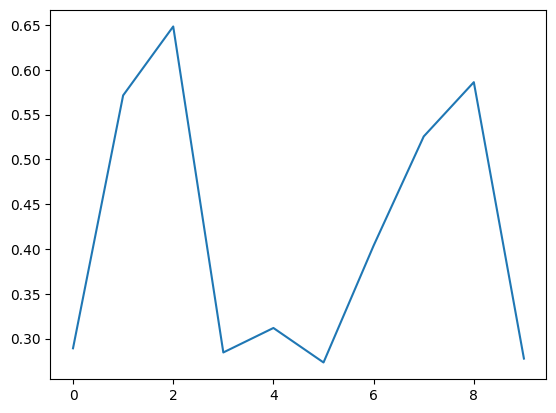

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(rouge)),rouge)

In [ ]:
for i in range(len(bart_data_gold)):
  tgt = bart_data_gold[i]['tgt']

In [ ]:
pre = []
for i in range(len(out)):
  pre.append(out[i]['summary_text'])

In [ ]:
rouge_1= scorer.score(pre,tgt)

AttributeError: ignored

In [ ]:
predict = sum(bart_data_gold[99]['src'])
predict

Your max_length is set to 1024, but your input_length is only 357. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=178)


[{'summary_text': "the civil engineering contractors association would value the growth of the welsh baccalaureate . ed evans thought that employers did n't understand it , but if they did , they would appreciate this . for his sector , especially the contracting sector , which depends very much on pupils who had come through from a less academic background , the institution gave them the ability not to pursue so much of an academic focus , but to test them in terms of the challenges , but also , to learn more directly from industry ."}]

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(predict[0]['summary_text'],bart_data_gold[99]['tgt'])
scores

In [ ]:
max(rouge_mean)

0.68

In [ ]:
train_out = sum(train[0])

RuntimeError: ignored

In [ ]:
train = []
for i in range(len(bart_data_gold)):
  train.append(bart_data_gold[i]['src'])